In [186]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса

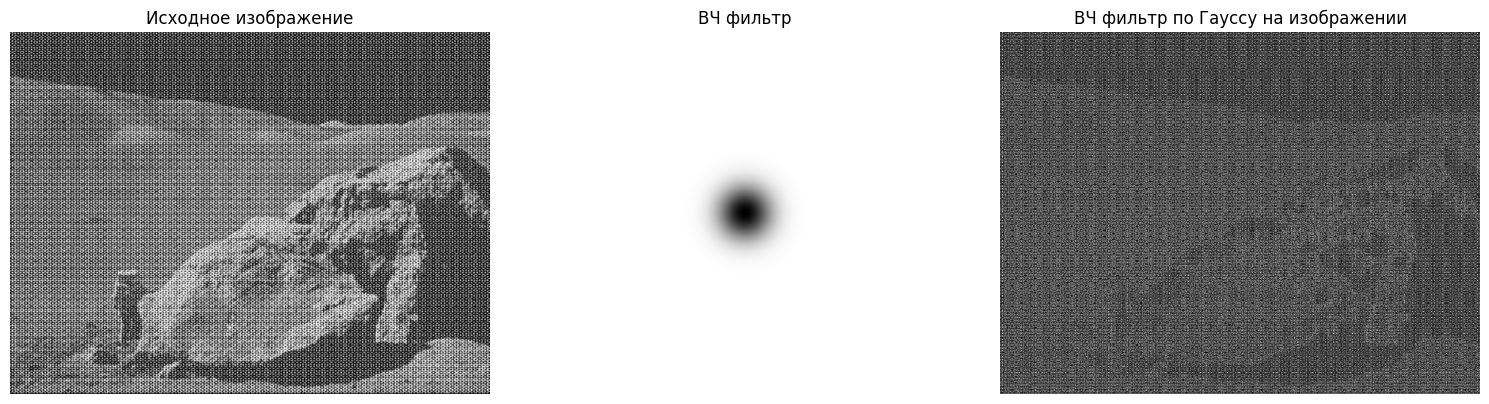

In [187]:
image = cv.imread('periodic_noise.jpg')
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 

def gaussian_highpass_filter(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    rows, cols = image.shape
    x, y = np.ogrid[:rows, :cols]
    center_x, center_y = rows // 2, cols // 2
    
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    sigma = 30
    gaussian_lowpass = np.exp(-(distance**2) / (2 * (sigma**2)))
    gaussian_highpass = 1 - gaussian_lowpass
    
    mask = np.zeros((rows, cols, 2), np.float32)
    mask[:,:,0] = gaussian_highpass
    mask[:,:,1] = gaussian_highpass
    
    dft_shift_filtered = dft_shift * mask
    f_ishift = np.fft.ifftshift(dft_shift_filtered)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return img_back, gaussian_highpass

highpass_result, gaussian_mask = gaussian_highpass_filter(image_gray)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('Исходное изображение'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(gaussian_mask, cmap='gray'); plt.title('ВЧ фильтр'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(highpass_result, cmap='gray'); plt.title('ВЧ фильтр по Гауссу на изображении'); plt.axis('off')
plt.tight_layout()
plt.show()

# Реализуйте удаление периодического шума

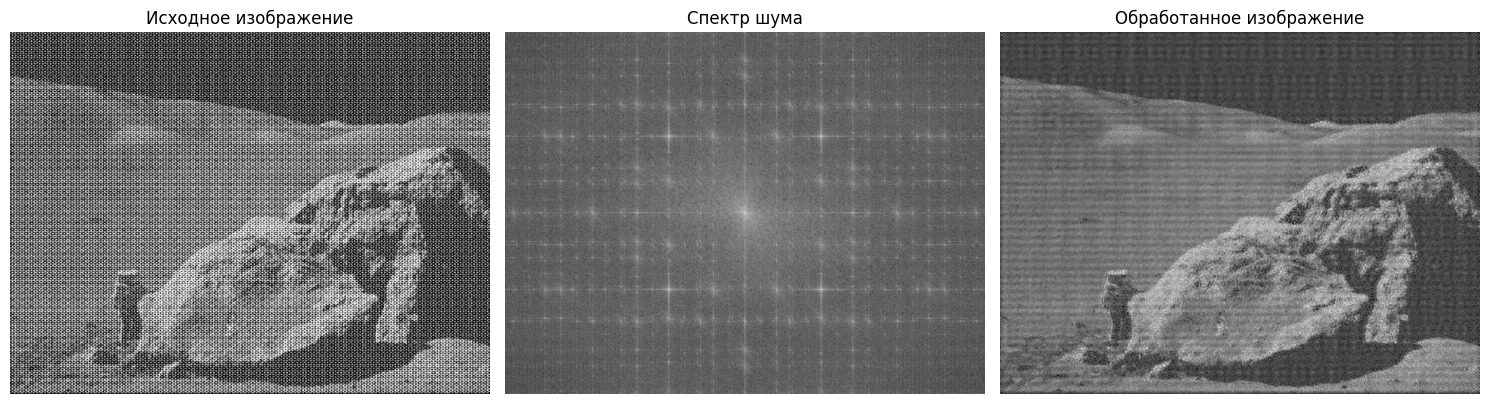

In [188]:
def remove_periodic_noise(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    magnitude = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    threshold = np.percentile(magnitude, 96)
    noise_mask = magnitude > threshold
    
    rows, cols = image.shape
    center_y, center_x = rows // 2, cols // 2
    center_radius = min(rows, cols) // 10
    
    filter_mask = np.ones((rows, cols, 2), np.float32)
    
    for y in range(rows):
        for x in range(cols):
            if noise_mask[y, x]:
                dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                if dist > center_radius:
                    filter_mask[y, x] = 0
                    filter_mask[rows-1-y, cols-1-x] = 0
    

    fshift = dft_shift * filter_mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])

    denoised_image = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return denoised_image, magnitude

denoised_image, magnitude = remove_periodic_noise(image_gray)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_gray, cmap='gray'); plt.title('Исходное изображение'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(magnitude, cmap='gray'); plt.title('Спектр шума'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(denoised_image, cmap='gray'); plt.title('Обработанное изображение'); plt.axis('off')
plt.tight_layout()
plt.show()